In [ ]:
# !pip install tomotopy
# import tomotopy as tp

In [ ]:
# !pip install tmplot
# import tmplot

In [1]:
import re
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import Counter

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, Phrases
from sklearn.feature_extraction.text import TfidfVectorizer
from rich.console import Console
from rich.table import Table
import pyLDAvis
import pyLDAvis.gensim

from tqdm.notebook import tqdm

# 1 Data Preprocessing

## 1-1 Exploratory Data Analysis

In [2]:
#### Load Data
# Create the list of brand name as the search key
# {"Fiat": "_", "Mini": "Jul 9, 2019", "VW": "Feb 14, 2014", "Pg": "Feb 25, 2019"}
dic_brand = {"Fiat":"Nov 20, 2022", "Mini":"Jun 9, 2018", "VW":"Oct 14, 2018", "Pg":"Feb 25, 2019", "Tesla":"Aug 30, 2019"}
df_all = []
l_brand = []
date_launch = []
#### Load data by brand
for key, date in dic_brand.items():
# create paths for post and comment data
    path_comment = "/Data_NLP/" + key + "_comment_info_c1.csv"
    df_all.append(pd.read_csv(path_comment))
    l_brand.append(key)
    date_launch.append(pd.to_datetime(date, format="%b %d, %Y"))
print("Launch Date:", date_launch)
df_all[0].info()

Launch Date: [Timestamp('2020-12-31 00:00:00'), Timestamp('2019-07-09 00:00:00'), Timestamp('2014-02-14 00:00:00'), Timestamp('2019-02-25 00:00:00'), Timestamp('2019-08-30 00:00:00')]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       730 non-null    int64  
 1   Comment_id       730 non-null    int64  
 2   Post_id          730 non-null    int64  
 3   Author           730 non-null    int64  
 4   Date             730 non-null    object 
 5   Comment_Content  730 non-null    object 
 6   Net_Likes        730 non-null    int64  
 7   Reply_id         730 non-null    float64
dtypes: float64(1), int64(5), object(2)
memory usage: 45.8+ KB


C:\Users\xiaoc\AppData\Local\Temp\ipykernel_12964\3473852956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["Date"] = pd.to_datetime(df_tmp["Date"],  format="%b %d, %Y")
C:\Users\xiaoc\AppData\Local\Temp\ipykernel_12964\3473852956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["Date"] = pd.to_datetime(df_tmp["Date"],  format="%b %d, %Y")
C:\Users\xiaoc\AppData\Local\Temp\ipykernel_12964\3473852956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

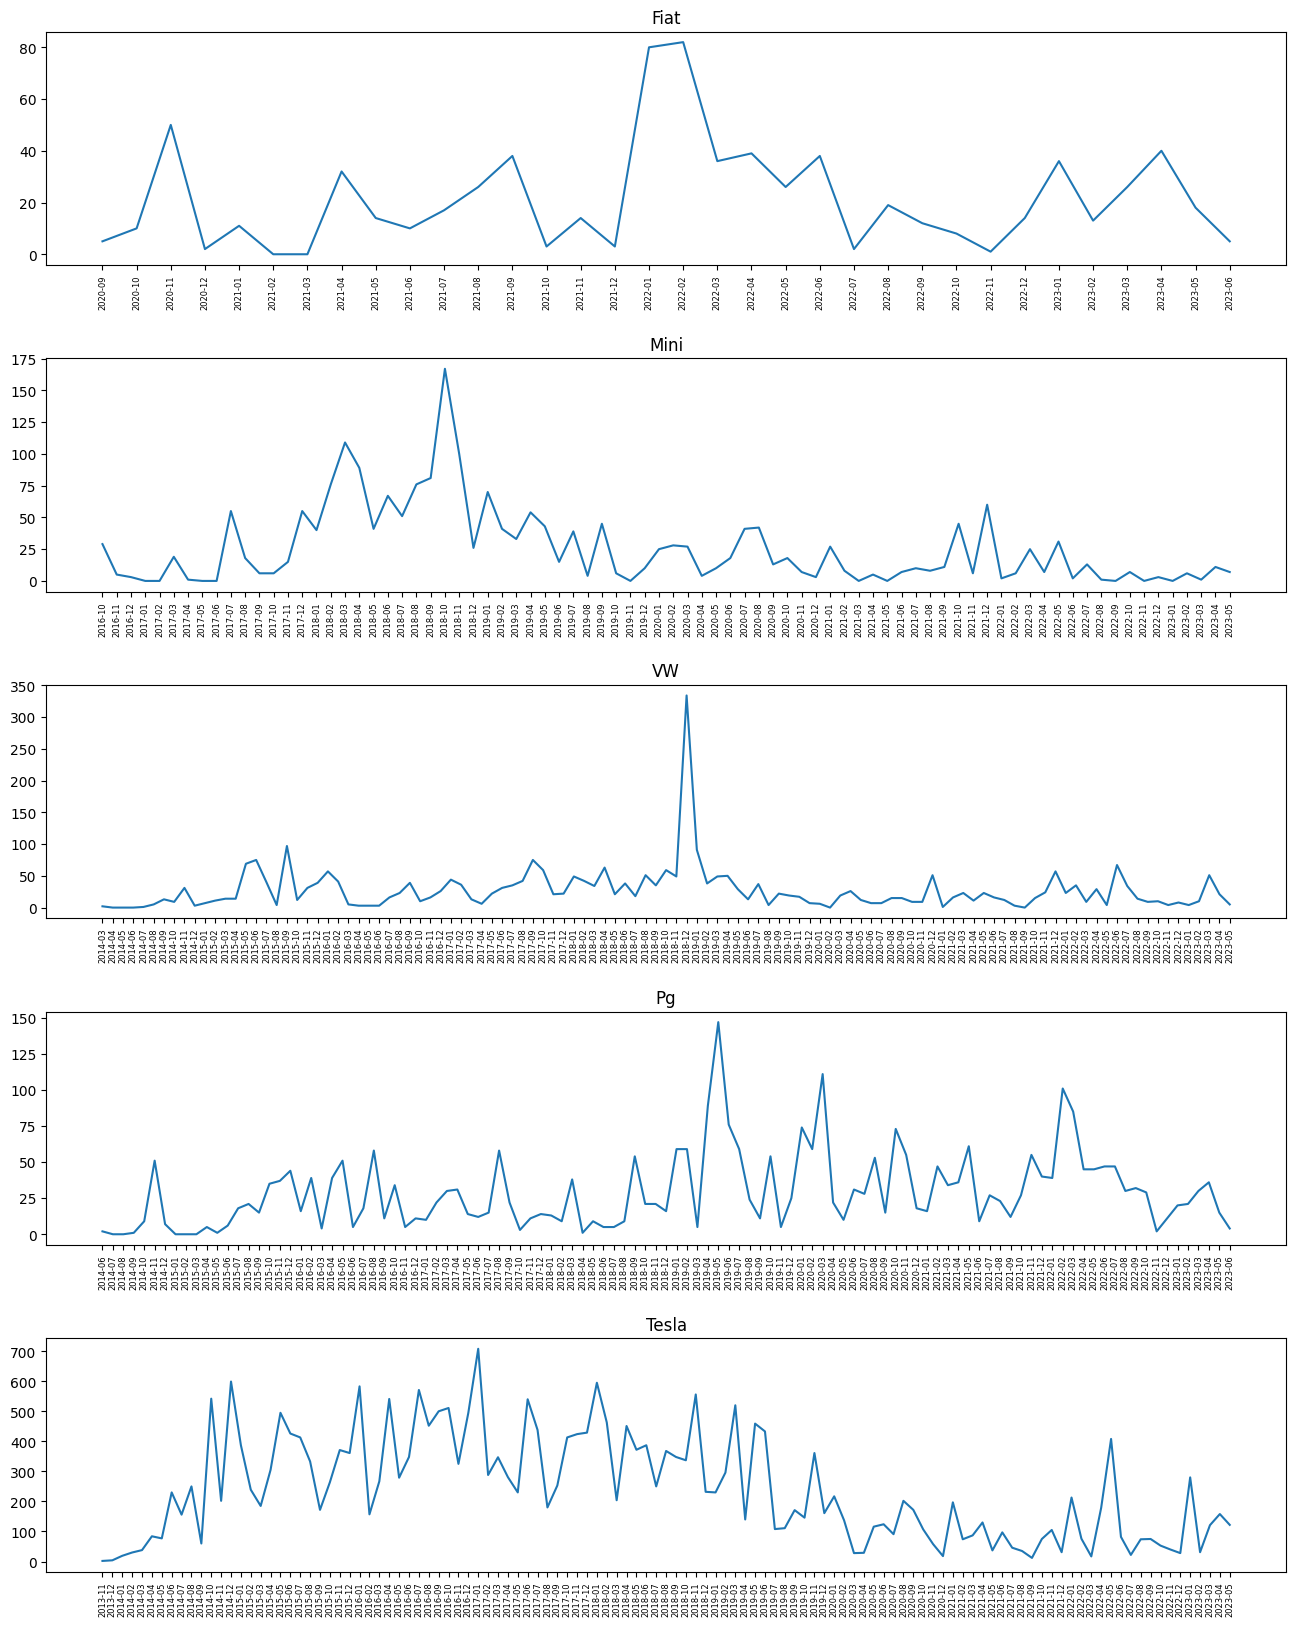

In [3]:
#### Visualise Data Distributions by Month of Each Brand
fig, axes = plt.subplots(5, 1, figsize=(16, 20))
for i in np.arange(len(dic_brand)):
    df_tmp = df_all[i][['Date', 'Comment_Content']]
    # Convert string to datetime
    df_tmp["Date"] = pd.to_datetime(df_tmp["Date"],  format="%b %d, %Y")
    # Resample data by month
    monthly_data = df_tmp.resample('M', on='Date')['Comment_Content'].count().reset_index()
    monthly_data["Date"] = monthly_data["Date"].dt.strftime('%Y-%m')
    axes[i].plot(monthly_data["Date"], monthly_data["Comment_Content"])
    axes[i].set_xticks(monthly_data["Date"])
    axes[i].set_xticklabels(monthly_data["Date"], rotation=90, fontsize=6)
    axes[i].set_title(f"{l_brand[i]}")
plt.subplots_adjust(hspace=0.4)
plt.show()

## 1-2 Text Tokenization with spaCy

In [104]:
#### Convert Date data type
# The list of dataframes that contain Date and Text
brand_index = 4
df_cmt = df_all[brand_index][['Date', 'Comment_Content']]
# Convert Date column's values from string into datetime
df_cmt['Date'] = pd.to_datetime(df_cmt['Date'], format="%b %d, %Y")

# Check the earliest date of the recorded comment
print(min(df_cmt['Date']))

C:\Users\xiaoc\AppData\Local\Temp\ipykernel_18348\1663444124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cmt['Date'] = pd.to_datetime(df_cmt['Date'], format="%b %d, %Y")


2013-11-21 00:00:00


In [105]:
#### Define data preprocess function
#### Load spaCy package
nlp = spacy.load("en_core_web_sm")
# and token.lemma_.lower() not in {}
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha
            and token.lemma_.lower() not in {f"{l_brand[brand_index].lower()}","gaz","say","car","go","think","need",
                                             "thank","know","come","ev","peugeot","volkswagen"}]

#### Tokenise data with spaCy for the classifier data
tkns_docs = [preprocess(text) for text in tqdm(df_cmt["Comment_Content"])]
# tkns_docs_before = [preprocess(text) for text in tqdm(l_data[0])]
# tkns_docs_after = [preprocess(text) for text in tqdm(l_data[1])]

  0%|          | 0/27707 [00:00<?, ?it/s]

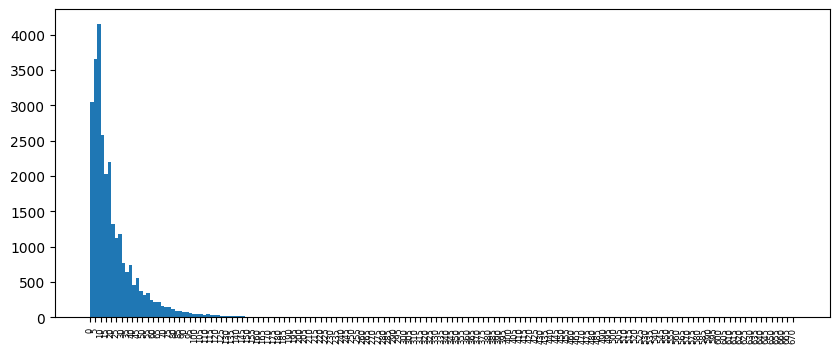

In [106]:
#### Check the distribution of the lengths
fig = plt.figure(figsize = (10, 4))
l_len = [len(text) for text in tkns_docs]
plt.hist(l_len, bins=200)
plt.xticks(ticks=np.arange(0, max(l_len), step=5))
plt.tick_params(axis='x', labelsize=6, rotation = 90)

In [107]:
#### Exclude texts that are too short
tkns_docs_cut = [text for text in tkns_docs if len(text) >= 3]
print(len(tkns_docs_cut))

#### Train model to capture bigram
bigram = Phrases(
    tkns_docs,
    min_count=3,
    threshold=1
)
tkns_docs_bi = [bigram[tkn] for tkn in tkns_docs_cut]

25744


# 2 Train the model

## Approach 0: Simple NLP EDA

### 0-1: Most Frequent Words in BoW

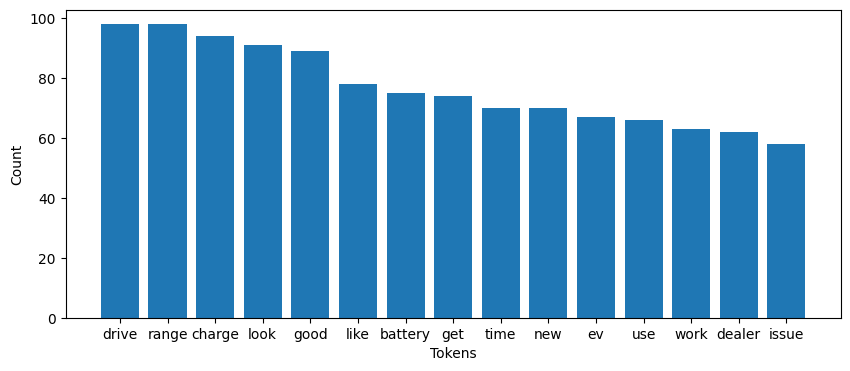

In [27]:
#### Check the most common words
flat_tkns_docs = [item for sublist in tkns_docs_bi for item in sublist]
l_cnt= Counter(flat_tkns_docs).most_common(15)
df_bow = pd.DataFrame(l_cnt, columns=["Token", "Count"])

#### Visualise the common tokens
fig = plt.figure(figsize=(10, 4))
plt.bar(df_bow['Token'], df_bow['Count'])
plt.xlabel('Tokens')
plt.ylabel('Count')

plt.show()

## Approach 1: Gensim

### 1-1 Create necessary documents

In [108]:
# Create a dictionary representation of the documents
dic = Dictionary(tkns_docs_bi)
# Filter out words that occur less than 20 documents, or more than 50% of the documents
dic.filter_extremes(no_below=3, no_above=0.5)
# Create bag-of-words representation of the documents (Corpus)
corpus = [dic.doc2bow(doc) for doc in tkns_docs_bi]

### 1-2 Iterate the Optimal Number of Topics

In [109]:
# Loop through different numbers of topics
cvs = {}
for topic_number in range(3, 11, 1):
    # Create and train the LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dic, num_topics=topic_number, passes=20, random_state=11)
    # Calculate coherence score u_mass & c_v ?
    coherence_model = CoherenceModel(model=lda_model, texts=tkns_docs_bi, dictionary=dic, coherence='c_v')
    coherence = coherence_model.get_coherence()
    # Store coherence value
    cvs[topic_number] = coherence
    print(f'Number of Topics: {topic_number}\tCoherence Score: {coherence}')

Number of Topics: 3	Coherence Score: 0.6220302659424757
Number of Topics: 4	Coherence Score: 0.602847858734241
Number of Topics: 5	Coherence Score: 0.5988405922443232
Number of Topics: 6	Coherence Score: 0.6125751814887682
Number of Topics: 7	Coherence Score: 0.5445606772052776
Number of Topics: 8	Coherence Score: 0.5882930183418914
Number of Topics: 9	Coherence Score: 0.5767087695525542
Number of Topics: 10	Coherence Score: 0.5321980777837818


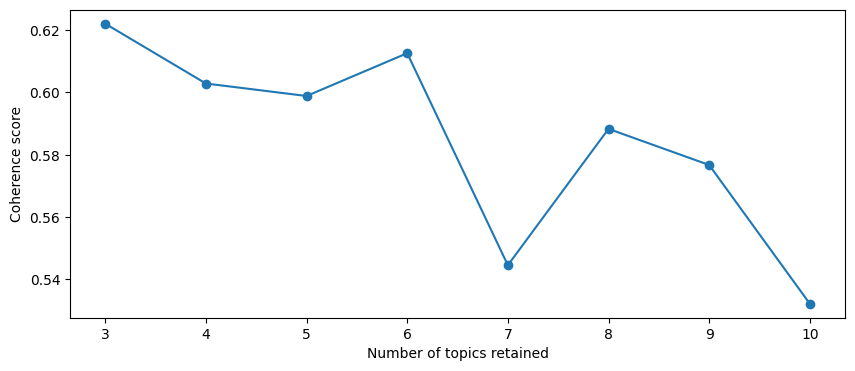

In [110]:
#### Visualise the coherence scores
fig = plt.figure(figsize = (10, 4))
plt.plot(cvs.keys(), cvs.values(), "o-")
plt.xlabel("Number of topics retained")
plt.ylabel("Coherence score")
plt.xticks(range(3, 11, 1))

plt.show()

In [111]:
#### Train the model with the best topic numbers
num_topic = 3
best_mdl = LdaModel(corpus=corpus, id2word=dic, num_topics=num_topic, passes=20, random_state=11)

In [112]:
#### Exhibit most related tokens under each topic before the date
console = Console()
word_num = 8
table = Table(
    show_header=True,
    header_style="cyan",
    title=f"[bold] [cyan] Word to topic probabilities (top {word_num} words)[/cyan]",
    width=130,
)
table.add_column("Topic", justify="center", style="cyan", width=15)
for i in range(1, word_num+2):
    table.add_column(f"W {i}", width=20)
# Obtain the top N words for each topic
topics = best_mdl.show_topics(formatted=False, num_topics=num_topic, num_words=word_num)
for k, topic in topics:
    values = [f"{word}\n({np.round(prob, 5)})\n" for word, prob in topic]
    table.add_row(str(k+1), *values)

console.print(table)

                                             Word to topic probabilities (top 8 words)                             
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━
┃ Topic ┃ W 1        ┃ W 2        ┃ W 3         ┃ W 4        ┃ W 5         ┃ W 6        ┃ W 7         ┃ W 8        
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━
│   1   │ drive      │ like       │ time        │ thing      │ look        │ driver     │ good        │ road       
│       │ (0.007679… │ (0.006570… │ (0.0056099… │ (0.004480… │ (0.0037599… │ (0.003680… │ (0.0036700… │ (0.003640… 
│       │            │            │             │            │             │            │             │            
│   2   │ year       │ model      │ buy         │ model_s    │ like        │ price      │ cost        │ market     
│       │ (0.006860… │ (0.006599… │ (0.0053199… │ (0.004829… │ (0.0047599… │ (0.004430… │ (0.0041299… │ (0.003890… 
│       │            │            │             │            │             │            │             │            
│   3   │ charge     │ superchar… │ use         │ charger    │ time        │ work       │ battery     │ site       
│       │ (0.013020… │ (0.006940… │ (0.0059299… │ (0.005539… │ (0.0048299… │ (0.004310… │ (0.0041200… │ (0.003909… 
│       │            │            │             │            │             │            │             │            
└───────┴────────────┴────────────┴─────────────┴────────────┴─────────────┴────────────┴─────────────┴────────────

In [113]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_mdl, corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.148008  0.093005       1        1  37.971539
0      0.014106 -0.163676       2        1  32.708137
2     -0.162114  0.070671       3        1  29.320324, topic_info=             Term         Freq        Total Category  logprob  loglift
26         charge  1996.000000  1996.000000  Default  30.0000  30.0000
622  supercharger  1064.000000  1064.000000  Default  29.0000  29.0000
46          drive  1510.000000  1510.000000  Default  28.0000  28.0000
279       charger   849.000000   849.000000  Default  27.0000  27.0000
463         model  1440.000000  1440.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
437          sure   405.863737  1384.547917   Topic3  -5.9338  -0.0002
359          like   460.829846  2529.705199   Topic3  -5.8068  -0.4759
204         point   379.096459  1240.328543   Topic3  -6.0021   0.0415
60           good   362.347981  1494.403913   Topic3  -6.0473  -0.1900
336          look   363.200440  1616.505638   Topic3  -6.0449  -0.2662

[211 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7520      3  0.996765        ac
754       2  0.994878  accident
440       1  0.380612  actually
440       2  0.352145  actually
440       3  0.266744  actually
...     ...       ...       ...
381       2  0.370886      work
381       3  0.404547      work
157       1  0.860392      year
157       2  0.085281      year
157       3  0.054327      year

[259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [114]:
#### Get the highest topic probability contribution of each text
# Re-generate the corpus of full data
tkns_docs_bi_full = [bigram[tkn] for tkn in tkns_docs]
# Create bag-of-words representation of the documents (Corpus)
corpus_full = [dic.doc2bow(doc) for doc in tkns_docs_bi_full]

def format_topics_sentences(ldamodel=best_mdl, corpus=corpus_full, oridata=df_cmt):
    # Init output
    sent_topics = []
    num_na = 0
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        if not row:
            num_na = num_na + 1
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                tmp_info = {'Dominant_Topic':int(topic_num), 'Perc_Contribution':round(prop_topic,4), 'Topic_Keywords':topic_keywords}
                sent_topics.append(tmp_info)
            else:
                break
    print(f"{num_na} comments can't be categorised")
    sent_topics_df = pd.DataFrame(sent_topics)

    # Add original text to the end of the output
    # contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, oridata], axis=1)
    return(sent_topics_df)

# Get dataframes of topics before and after the date
df_topic_sents_keywords = format_topics_sentences(ldamodel=best_mdl, corpus=corpus_full, oridata=df_cmt)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Date', 'Text']
df_dominant_topic

0 comments can't be categorised


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Date,Text
0,0,1,0.5990,"year, model, buy, model_s, like, price, cost, ...",2015-02-11,...\n\nAs the Roadster has 194 miles ideal ran...
1,1,2,0.6595,"charge, supercharger, use, charger, time, work...",2015-02-11,"Conclusion\n\nIn summary, it can been seen tha..."
2,2,0,0.9445,"drive, like, time, thing, look, driver, good, ...",2015-02-11,Wow! That's got to be the most comprehensive a...
3,3,1,0.4342,"year, model, buy, model_s, like, price, cost, ...",2015-02-12,@dpeilow\n\nThanks for posting such an interes...
4,4,0,0.5708,"drive, like, time, thing, look, driver, good, ...",2015-02-12,"So, some questions, @dpeilow , hope you don't ..."
...,...,...,...,...,...,...
27702,27702,1,0.7480,"year, model, buy, model_s, like, price, cost, ...",2014-01-17,"Would love to work with/for Tesla, but that's ..."
27703,27703,1,0.5076,"year, model, buy, model_s, like, price, cost, ...",2014-01-20,I would love to work for Tesla as well. Does a...
27704,27704,1,0.7034,"year, model, buy, model_s, like, price, cost, ...",2014-01-21,"engineer is a pretty broad term, assume they a..."
27705,27705,0,0.7081,"drive, like, time, thing, look, driver, good, ...",2013-11-21,This is one big media storm in a teacup and El...


In [115]:
#### Find the top 5 representative document for each topic
# Sort values within groups
df_top_topic = df_dominant_topic.sort_values(['Dominant_Topic', 'Topic_Perc_Contrib'], ascending=[True, False])
# Get top 5 for each group
top_records = df_top_topic.groupby('Dominant_Topic').head(5)
# Save the document
top_records.to_csv(f"{l_brand[brand_index]}_Top_records_all.csv", header=True)
df_top_topic[['Dominant_Topic', 'Date', 'Text']].to_csv(f"{l_brand[brand_index]}_topic_dis.csv", header=True)

In [116]:
#### Split topics distribution before/after a date
# Split data
# Data of before and after distribution by Topic
df_before = df_dominant_topic[df_dominant_topic['Date'] < date_launch[brand_index]]
topic_count_0 = df_before['Dominant_Topic'].value_counts()
df_before_0 = pd.DataFrame(topic_count_0).reset_index().sort_values(['Dominant_Topic'], ascending=[True])

df_after = df_dominant_topic[df_dominant_topic['Date'] >= date_launch[brand_index]]
topic_count_1 = df_after['Dominant_Topic'].value_counts()
df_after_1 = pd.DataFrame(topic_count_1).reset_index().sort_values(['Dominant_Topic'], ascending=[True])
# Store data into a dataframe list
l_topic_vis_0 = [df_before_0, df_after_1]

# Data distribution by Date & Topic
topic_count_2 = df_dominant_topic[["Dominant_Topic", "Date"]].groupby('Dominant_Topic').resample('M', on='Date').size().reset_index()
topic_count_2["Date"] = topic_count_2["Date"].dt.strftime('%Y-%m')
topic_count_2.columns = ["Dominant_Topic", "Date", "count"]
df_pivot_2 = topic_count_2.pivot(index='Date', columns='Dominant_Topic', values='count').fillna(0)
df_vis_2 = df_pivot_2.reset_index()
# # Data of before and after distribution by Date & Topic
# topic_count_3 = df_after.groupby('Dominant_Topic').resample('M', on='Date').size().reset_index()
# topic_count_3["Date"] = topic_count_3["Date"].dt.strftime('%Y-%m')
# topic_count_3.columns = ["Dominant_Topic", "Date", "count"]
# df_pivot_3 = topic_count_3.pivot(index='Date', columns='Dominant_Topic', values='count').fillna(0)

# Check lengths
print(len(df_before), len(df_after))

22657 5050


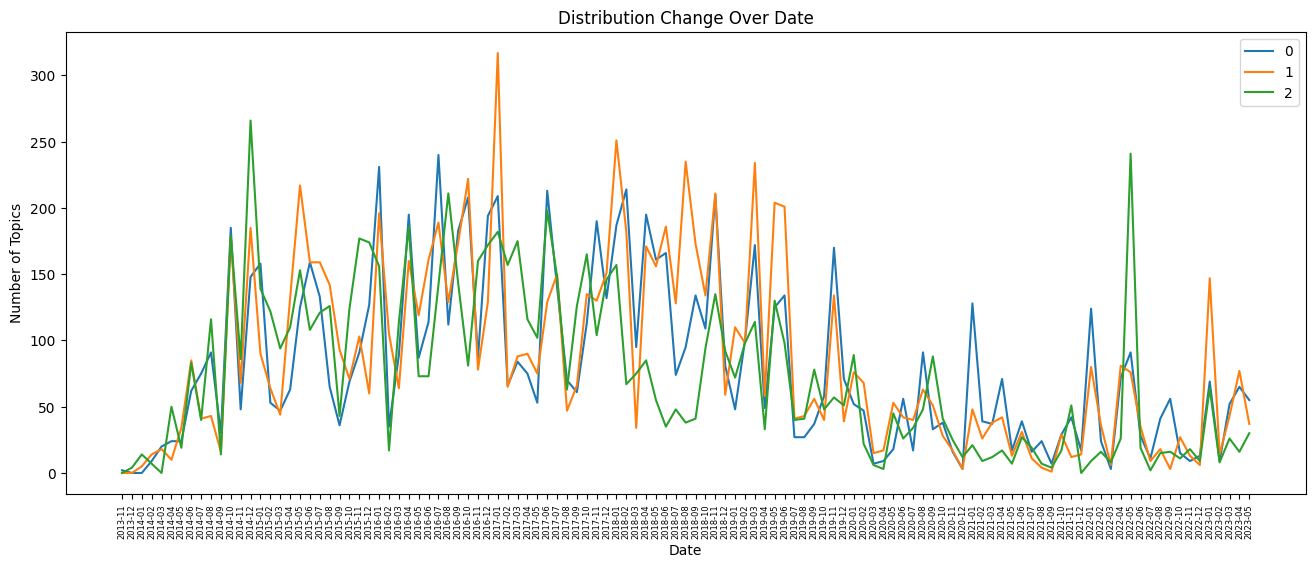

In [117]:
#### Visualise the distribution of topics over time
fig = plt.figure(figsize=(16, 6))
for i in df_vis_2.columns[1:]:
    plt.plot(df_vis_2["Date"], df_vis_2[i], label=i)
plt.xlabel('Date')
plt.ylabel('Number of Topics')
plt.tick_params(axis='x', labelsize=6, rotation = 90)
plt.title('Distribution Change Over Date')
plt.legend()
plt.show()

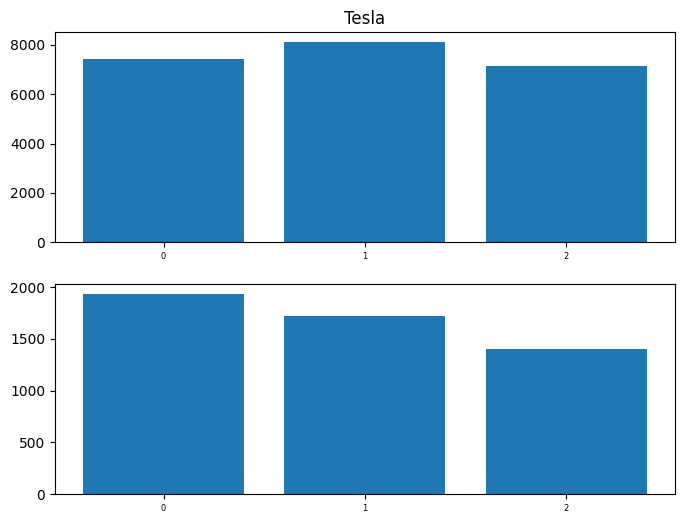

In [118]:
#### Visualise topics distribution before/after a date
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
axes[0].set_title(f"{l_brand[brand_index]}")
for i in np.arange(len(l_topic_vis_0)):
    axes[i].bar(l_topic_vis_0[i]["Dominant_Topic"], l_topic_vis_0[i]["count"])
    axes[i].set_xticks(l_topic_vis_0[i]["Dominant_Topic"])
    axes[i].set_xticklabels(l_topic_vis_0[i]["Dominant_Topic"], fontsize=6)